## FINGER TAPPING ANALYSIS
##### Data collected from patients with neurodegenerative disorders as well as healthy controls

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import time
import sys
from tqdm import tqdm
import os
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import math
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import keras
from keras.models import Model
from keras.layers import Input, Conv1D, Flatten, Dropout, MaxPooling1D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

C:\Users\Korisnik\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Define MEASUREMENT class and stuff

In [7]:
#import tensorflow as tf

In [8]:
class measurement:
    def __init__(self, gyro1x, gyro1y, gyro1z,gyro2x, gyro2y, gyro2z,
                 tap_task, time, time_tap, ttapstart, ttapstop, diagnosis,
                 initials, date, timeOfMeasurement):
        
        # acceleration
#         self.acc1x = acc1x # thumb
#         self.acc1y = acc1y # thumb
#         self.acc1z = acc1z # thumb
#         self.acc1Vec = np.sqrt(np.square(self.acc1x)+
#                                np.square(self.acc1y)+
#                                np.square(self.acc1z))
        
#         self.acc2x = acc2x # forefinger
#         self.acc2y = acc2y # forefinger
#         self.acc2z = acc2z # forefinger
#         self.acc2Vec = np.sqrt(np.square(self.acc2x)+
#                                np.square(self.acc2y)+
#                                np.square(self.acc2z))
        
        # force
        #self.fsr = fsr
                
        # angular velocity
        self.gyro1x = gyro1x # thumb
        self.gyro1y = gyro1y # thumb
        self.gyro1z = gyro1z # thumb
        self.gyro1Vec = np.sqrt(np.square(self.gyro1x)+
                                np.square(self.gyro1y)+
                                np.square(self.gyro1z))
        
        self.gyro2x = gyro2x # forefinger
        self.gyro2y = gyro2y # forefinger
        self.gyro2z = gyro2z # forefinger
        self.gyro2Vec = np.sqrt(np.square(self.gyro2x)+
                                np.square(self.gyro2y)+
                                np.square(self.gyro2z))        
        
               
        # other
        self.tap_task = tap_task # LHEO/LHEC/RHEO/RHEC (left or right hand/eyes open or closed)
        self.time = time
        self.time_tap = time_tap
        self.ttapstart = ttapstart+0.3 #single value, when the actual signal started SECONDS
        self.ttapstop = ttapstop-0.3 #single value, when the actual signal stopped SECONDS
        self.diagnosis = diagnosis # PD, PSP, MSA, CTRL
        self.initials = initials # person name and surname initials 
        self.date = date # date of recording
        self.timeOfMeasurement = timeOfMeasurement #what time that date
        self.length = len(gyro1x)
        self.tappingLength = self.ttapstop - self.ttapstart
        self.fs = 200 # sampling rate [Hz]
        #self.mvcSustained = max(self.fsr[0:int(ttapstart*self.fs)])
        #self.mvcTapping = max(self.fsr[int(ttapstart*self.fs):int(ttapstop*self.fs)])
        #self.mvcTotal = self.mvcTapping if self.mvcTapping>self.mvcSustained else self.mvcSustained
        
        
        #normalize gyro
        denominator1 = max(np.max(self.gyro1x[int(ttapstart*self.fs):int(ttapstop*self.fs)]),
                           np.max(self.gyro1y[int(ttapstart*self.fs):int(ttapstop*self.fs)]),
                           np.max(self.gyro1z[int(ttapstart*self.fs):int(ttapstop*self.fs)]))
        
        denominator2 = max(np.max(self.gyro2x[int(ttapstart*self.fs):int(ttapstop*self.fs)]),
                           np.max(self.gyro2y[int(ttapstart*self.fs):int(ttapstop*self.fs)]),
                           np.max(self.gyro2z[int(ttapstart*self.fs):int(ttapstop*self.fs)]))
        
        self.gyro1x,self.gyro1y,self.gyro1z = self.gyro1x/denominator1,self.gyro1y/denominator1,self.gyro1z/denominator1
        self.gyro2x,self.gyro2y,self.gyro2z = self.gyro2x/denominator2,self.gyro2y/denominator2,self.gyro2z/denominator2

        
        # normalize FSR
#         self.normalizedFSR = self.fsr/self.mvcSustained
        self.id = self.diagnosis + '_' + self.initials + '_' +self.date 
        
    def packAndCrop(self, seconds):
        
        # matrix for feeding into a net
        # shape: nsignals(13 or 5 probably) x seconds*SamplingRate 
        

        allPacked = np.concatenate(([self.gyro1x],[self.gyro1y],[self.gyro1z],
                                    [self.gyro2x],[self.gyro2y],[self.gyro2z]), axis=0) 
        nRows = allPacked.shape[0]
        
        allPacked = allPacked[:, int(self.fs*self.ttapstart):int(self.fs*self.ttapstop)]
        
        crops = []
        
        modelPackage = np.zeros((nRows,seconds*self.fs),dtype='float16')
        fin = allPacked.shape[1] if allPacked.shape[1]<seconds*self.fs else seconds*self.fs
        modelPackage[:,:fin] = allPacked[:,:fin]
        
        crops.append(modelPackage)
        
        nCrops = int((allPacked.shape[1] - seconds*self.fs)/self.fs)
        for i in range(nCrops):
            temp = allPacked[:,((i+1)*self.fs):((i+1)*self.fs + seconds*self.fs)]
            #temp = np.transpose(temp)
            crops.append(temp)
            
        
        return crops
       
    def sumUp(self):
        temp = {'lenGyroThumb': len(self.gyro1x),
               'lenGyroForefinger': len(self.gyro2x),
               'lenTime': len(self.time)}
        temp['MATCHING_LENGTHS'] =  len(set(temp.values()))==1
        temp['durationInSecs'] = self.length/self.fs
        return temp
    
    def plotSignals(self, xlim = []):
        # Optionally pass a tuple for zooming in on the x axis (xmin,xmax)
        if len(xlim) <2:
            xlim = (0,self.length/self.fs)
            
#         # accelerometers     
#         plt.figure(figsize=(16,12))
# #         plt.plot(self.time,self.acc1x)
# #         plt.plot(self.time,self.acc1y)
# #         plt.plot(self.time,self.acc1z)
# #         plt.plot(self.time,self.acc2x)
# #         plt.plot(self.time,self.acc2y)
# #         plt.plot(self.time,self.acc2z)
#         plt.axvline(x = self.ttapstart,color = 'b')
#         plt.axvline(x = self.ttapstop, color = 'r')
#         plt.xlim(xlim)
#         plt.legend(('AccThumbX', 'AccThumbY', 'AccThumbZ',
#                     'AccIndexX', 'AccIndexY', 'AccIndexZ'))
#         plt.title('Accelerometers for subject ' + self.initials +
#                   ' Date: ' + self.date +
#                   ' Diagnosis: ' + self.diagnosis +
#                    'Task: ' + self.tap_task)
#         plt.show()
        
#         # vector accelerometer
#         plt.figure(figsize=(16,5))
#         plt.plot(self.time, self.acc1Vec)
#         plt.plot(self.time, self.acc2Vec)
#         plt.axvline(x = self.ttapstart,color = 'b')
#         plt.axvline(x = self.ttapstop, color = 'r')
#         plt.xlim(xlim)
#         plt.legend(('AccThumbVector', 'AccIndexVector'))
#         plt.title('Accelerometer Vectors')
#         plt.show()
        
        # gyro1
        plt.figure(figsize = (16,5))
        plt.plot(self.time,self.gyro1x)
        plt.plot(self.time,self.gyro1y)
        plt.plot(self.time,self.gyro1z)
        plt.legend(['GyroThumbX', 'GyroThumbY', 'GyroThumbZ'])
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.title('Gyro THUMB data')
        
        # gyro2
        plt.figure(figsize = (16,5))
        plt.plot(self.time,self.gyro2x)
        plt.plot(self.time,self.gyro2y)
        plt.plot(self.time,self.gyro2z)
        plt.legend(['GyroIndexX', 'GyroIndexY', 'GyroIndexZ'])
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.title('Gyro INDEX data')
        
        # vector gyro
        plt.figure(figsize=(16,5))
        plt.plot(self.time, self.gyro1Vec)
        plt.plot(self.time, self.gyro2Vec)
        plt.axvline(x = self.ttapstart,color = 'b')
        plt.axvline(x = self.ttapstop, color = 'r')
        plt.xlim(xlim)
        plt.legend(('GyroThumbVector', 'GyroIndexVector'))
        plt.title('Gyro Vectors')
        plt.show()
        
#         # force
#         plt.figure(figsize=(16,5))
#         plt.plot(self.time,self.normalizedFSR)
#         plt.xlim(xlim)
#         plt.axvline(x = self.ttapstart,color = 'b')
#         plt.axvline(x = self.ttapstop, color = 'r')
#         plt.title('Normalized FSR')
#         plt.show()
    

        
        
    

In [9]:
def readAdjust(root, directory, file):
    
    sig = scipy.io.loadmat(root + directory + '/' + file)
    
    temp = measurement(sig['gyro1'][0],
                       sig['gyro1'][1],
                       sig['gyro1'][2],
                       sig['gyro2'][0],
                       sig['gyro2'][1],
                       sig['gyro2'][2],
                       sig['tap_task'][0], 
                       sig['time'][0],
                       sig['time_tap'][0],
                       sig['ttapstart'][0,0], 
                       sig['ttapstop'][0,0], 
                       directory,
                       file[0:2], 
                       file[3:13],
                       file[14:22])
                           
    return temp
    

#### READ THE DATA

In [10]:
root = 'C:/Users/Korisnik/Desktop/Minjino/Tapping/Tapping raw data/'
_,dirs,_ = os.walk(root).__next__()

sigs = []
for d in tqdm(dirs):
    _,_,files = os.walk(root+d).__next__()
    sigs = sigs +[readAdjust(root, d, file) for file in files]
    
    

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


##### Check if everything's okay.

In [ ]:
#### NEEDN'T RUN #####

sigs[12].sumUp()
print('INFO:')
print('There are a total of {} files'.format(len(sigs)))

temp = [s.sumUp()['MATCHING_LENGTHS'] for s in sigs]
if len(set(temp))==1:
    print('All signals contain gyro and fsr data of the same length')
else:
    print('Some files contain data of unequal lengths')

    
sigs[8].plotSignals([0,10])


## Repack for input to a network

In [13]:
# Minimal length of signals?

m = 10000
i = 1
for ix,sig in enumerate(sigs):
    if sig.tappingLength < m:
        m = sig.tappingLength
        i = ix
        
# The shortest signal is sigs[86], corresponding to a CTRL, rhec. Lasts a total of 12s, and 7.25s of active tapping.
# Going to remove those with active signal <10s...maybe
print('Shortest length: {}s, found for signal number {} '.format(m,i))


Shortest length: 7.25s, found for signal number 86 


In [14]:
def encodeDiagnosis(diagnosis):
    le = LabelEncoder()
    le.fit(['CTRL','MSA','PD','PSP'])
    # This is the encoding:
    # CTRL -----> 0 -----> [1,0,0,0]
    # MSA ----->  1 -----> [0,1,0,0]
    # PD -----> 2 -----> [0,0,1,0]
    # PSP -----> 3 -----> [0,0,0,1]
    
    diagnosis = le.transform([diagnosis])
    oneHotDiagnosis = np.zeros((1,4),dtype='uint8')
    idx = diagnosis[0]
    oneHotDiagnosis[0][idx] = 1
    return oneHotDiagnosis[0]

  
    

In [50]:
# Distribution of classes?
def classDistribution(sigs):
    diagnoses = [sig.diagnosis for sig in sigs]
    CTRL = np.sum([d =='CTRL' for d in diagnoses])
    PD = np.sum([d =='PD' for d in diagnoses])
    PSP = np.sum([d =='PSP' for d in diagnoses])
    MSA = np.sum([d =='MSA' for d in diagnoses])

    print('There are {} CTRL subjects, {} MSA, {} PD and {} PSP'. format(CTRL, MSA, PD, PSP))

    plt.bar(['CTRL','MSA','PD','PSP'],[CTRL,MSA,PD,PSP])
    plt.title('Number of signals recorded by diagnosis')
    plt.show()
    return {'CTRL':CTRL,'MSA':MSA,'PD':PD,'PSP':PSP}

There are 108 CTRL subjects, 161 MSA, 135 PD and 167 PSP


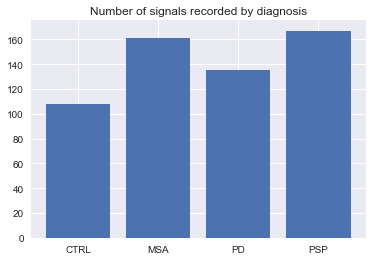

{'CTRL': 108, 'MSA': 161, 'PD': 135, 'PSP': 167}

In [52]:
d = classDistribution(sigs)

In [96]:
CTRLind = [i for i,sig in enumerate(sigs) if sig.diagnosis == 'CTRL']
MSAind = [i for i,sig in enumerate(sigs) if sig.diagnosis == 'MSA']
PDind = [i for i,sig in enumerate(sigs) if sig.diagnosis == 'PD']
PSPind = [i for i,sig in enumerate(sigs) if sig.diagnosis == 'PSP']

inds = [[CTRLind], [MSAind],[PDind],[PSPind]]




In [ ]:
def splitOneDiagnosis(DIAGind, trainPercent, testPercent):
    trainInd = np.random.choice(DIAGind,round(trainPercent*len(DIAGind)),replace = False)
    Xtrain =  [sigs[i] for i in trainInd]
    leftover = [i for i in DIAGind if i not in trainInd]
    
    testInd = np.random.choice(leftover,round(testPercent*len(DIAGind)), replace = False)
    Xtest = [sigs[i] for i in testInd]
    leftover = [i for i in leftover if i not in testInd]
    
    Xval = [sigs[i] for i in leftover]
    
    return Xtrain, Xtest, Xval

In [106]:
# Split into train, test, val sets

# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.3, random_state=1)
# Xtest, Xval, Ytest, Yval = train_test_split(Xtest, Ytest, test_size = 0.2, random_state =1)

trainPercent = 0.7
testPercent = 0.2
#valPercent = 0.1

np.random.seed(123)
dataTrain =[]
dataTest = []
dataVal = []

for DIAGind in inds:
    diagTrain, diagTest, diagVal = splitOneDiagnosis(DIAGind[0],trainPercent,testPercent) 
    dataTrain = dataTrain + diagTrain
    dataTest = dataTest + diagTest
    dataVal = dataVal + diagVal



400 114 57
There are 76 CTRL subjects, 113 MSA, 94 PD and 117 PSP


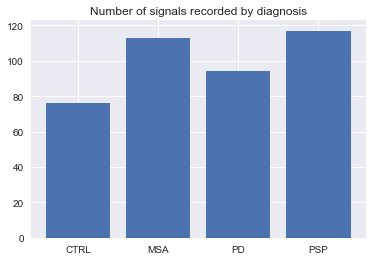

There are 22 CTRL subjects, 32 MSA, 27 PD and 33 PSP


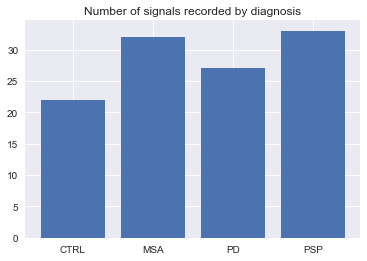

There are 10 CTRL subjects, 16 MSA, 14 PD and 17 PSP


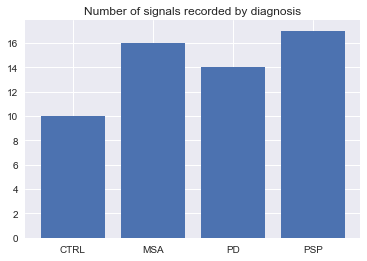

{'CTRL': 10, 'MSA': 16, 'PD': 14, 'PSP': 17}

In [107]:
print(len(dataTrain), len(dataTest), len(dataVal))
classDistribution(dataTrain)
classDistribution(dataTest)
classDistribution(dataVal)

In [111]:
# reshape data

def cropAndReshape(signals, nSeconds):
    #tic = time.time()
    X = []  # signals
    Y = []  # diagnoses
    for sig in tqdm(signals):
        crops = sig.packAndCrop(nSeconds)
        X = X + crops
        for i in range(0,len(crops)):
            Y.append(encodeDiagnosis(sig.diagnosis))
        
    Y = np.reshape(Y,(len(Y),4))
    X = np.reshape(X, (len(X),X[0].shape[0],X[0].shape[1]))
    X = np.swapaxes(X,1,2)
    print('Shape of X: ', X.shape)
    #toc = time.time()
    #print('Finished this operation in {} s'.format(toc-tic))
    return X,Y

In [112]:
nSeconds = 10
Xtrain, Ytrain = cropAndReshape(dataTrain,nSeconds)
Xtest, Ytest = cropAndReshape(dataTest,nSeconds)
Xval, Yval = cropAndReshape(dataVal,nSeconds)

100%|██████████| 400/400 [00:00<00:00, 1943.25it/s]


Shape of X:  (2719, 2000, 6)


100%|██████████| 114/114 [00:00<00:00, 1758.50it/s]


Shape of X:  (738, 2000, 6)


100%|██████████| 57/57 [00:00<00:00, 1393.99it/s]


Shape of X:  (375, 2000, 6)


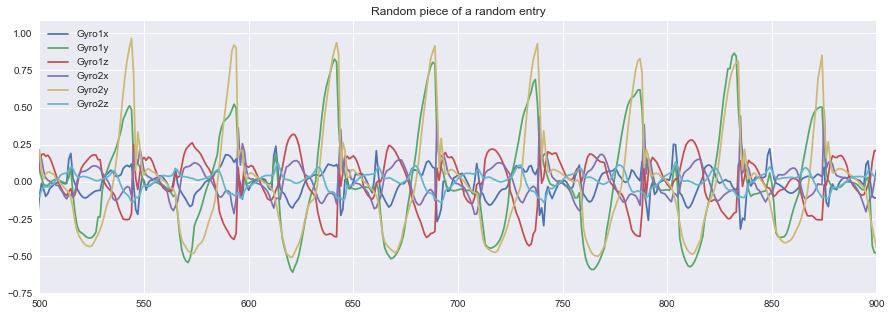

In [113]:
plt.figure(figsize = (15,5))
plt.plot(X[200])
plt.xlim(500,900)
plt.title('Random piece of a random entry')
plt.legend(['Gyro1x','Gyro1y','Gyro1z','Gyro2x','Gyro2y','Gyro2z','NormFSR'])
plt.show()

### Arite, lez make a model

In [115]:
def CNNModel(inputShape, nConvLayers):
    
    input1 = Input(shape = inputShape)

    #convolutions
    x = input1
    for i in range(0,nConvLayers):
        
        nFilters = 256 if i>1 else 64*(i+1)
        inside = 3 if i>1 else 2
        for temp in range(0,inside):
            x = Conv1D(filters = nFilters,
                  kernel_size = 5,
                  padding = 'same',
                  strides = 1,
                  name = 'Conv1x5{}{}'.format(i,temp))(x)
            x = BatchNormalization()(x)
            x = Activation('relu',name='ReLu{}{}'.format(i,temp))(x)
            
        x = MaxPooling1D(2,
                      padding = 'same',
                      strides = 1,
                      name = 'MaxPooling1D{}'.format(i))(x)
        x = Dropout(0.3)(x)

    
    # Fully connected
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(0.3)(x)
    x = Dense(64)(x)
    x = Dropout(0.3)(x)
    x = Activation('relu', name = 'reLU_dense')(x)
    x = Dense(4)(x)
    x = Activation('softmax',name = 'Softmax')(x)

    m = Model(input1,x)
    return m


In [116]:
def saveModelTopology(model,modelName):
    model_json = model.to_json()
    with open(modelName+'.json', "w") as json_file:
        json_file.write(model_json)
    print("Saved model to {}.json.".format(modelName))
    return


In [118]:
def defCallbacks(weightFile):
    
    checkpoint = ModelCheckpoint(weightFile,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode='max')
    early = EarlyStopping(monitor='val_acc',
                          patience = 10,
                          verbose = 1,
                          mode='max')
    return [checkpoint, early]
    

In [119]:
def fitModel(model, modelName, Xtrain, Ytrain, Xval, Yval, epochs):
    
    tic = time.time()
    
    # make file name
    tm = time.gmtime()
    weightFile = '{}.{}.{}.{}.{}.{}.h5'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])
    
    #define callbacks
    callbacks = defCallbacks(weightFile)
    
    # FIT THE MODEL
    history = model.fit(x = Xtrain, y = Ytrain,
                        epochs=epochs,
                        batch_size=4,
                        validation_data = (Xval,Yval),
                        callbacks = callbacks)
    toc = time.time()
    print("Finished training in {} min ({} h)".format(round((toc-tic)/60,2),round((toc-tic)/3600,2)))

    
    # Save the weights
    model.save_weights(str(modelName)+'.h5') # ???????
    
    return history

In [120]:
def evaluateModel(model, modelName, Xval, Yval):
    tic = time.time()
    predictions = model.predict(Xval)
    toc = time.time()
    print('Finished prediction in: {} min'.format(round((toc-tic)/60,2)))

    print('Evaluating...')
    score = model.evaluate(Xval,Yval,verbose=1)
    print(score)

    #Save that stuff too pls.
    tm = time.gmtime()    
    predictionFile = 'Predictions-{}.{}.{}.{}.{}.{}.csv'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])

    dfPredicted = pd.DataFrame(predictions)
    dfPredicted = dfPredicted.idxmax(axis =1)
    dfExpected = pd.DataFrame(Yval)
    dfExpected = dfExpected.idxmax(axis =1)
    df = pd.DataFrame({'Predicted':dfPredicted, 'Expected':dfExpected})
    df.to_csv(predictionFile,index = False)
    print('Saved predictions to: ', predictionFile)
    
    bingos = sum(df['Predicted'] ==df['Expected'])
    accRly = 100*bingos/df.shape[0]
    print('Currently your actual accuracy on Xval is: {}%'.format(round(accRly,2)))
    
    return accRly

In [121]:
histories = []
modelDepths = []
accuracies = []

for nConvLayers in range(3,5):
    model = CNNModel((Xtrain.shape[1],Xtrain.shape[2]),nConvLayers)
    opt = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    model.compile(optimizer = opt,
             loss='categorical_crossentropy',
             metrics = ['accuracy'])
    model.summary()
    modelName = 'CNN_{}_Layers_Deep'.format(nConvLayers)
    saveModelTopology(model,modelName)
    
    print('TRAINING...')
    epochs = 200
    history = fitModel(model,modelName, Xtrain, Ytrain, Xval, Yval, epochs)
    histories.append(history.history)   
    modelDepths.append(nConvLayers)
        
    # check how it went
    print(history.history)

    # plot Accuracy over Epochs
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train Acc','Val Acc'])
    plt.title('Accuracy for {} over epochs'.format(modelName))
    plt.show()

    # plot Loss over Epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss','Val Loss'])
    plt.title('Loss for {} over epochs'.format(modelName))
    plt.show()
    
    acc = evaluateModel(model, modelName, Xval, Yval)
    accuracies.append(acc)
    
    
    with open("hist.txt", "w") as f:
        for h in histories:
            f.write(str(h) +"\n")

#     with open("hist.txt", "r") as f:
#         for line in f:
#             histo.append(int(line.strip()))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000, 6)           0         
_________________________________________________________________
Conv1x500 (Conv1D)           (None, 2000, 64)          1984      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000, 64)          256       
_________________________________________________________________
ReLu00 (Activation)          (None, 2000, 64)          0         
_________________________________________________________________
Conv1x501 (Conv1D)           (None, 2000, 64)          20544     
_________________________________________________________________
batch_normalization_2 (Batch (None, 2000, 64)          256       
_________________________________________________________________
ReLu01 (Activation)          (None, 2000, 64)          0         
__________

KeyboardInterrupt: 